In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
directory = "/content/drive/My Drive/DataC102 Proj"

In [69]:
candidates = pd.read_csv("%s/candidate_summary_2018.csv" % directory)
dem = pd.read_csv("%s/dem_candidates.csv" % directory)
dem_cat = pd.read_csv("%s/dem-cat.csv" % directory)
rep_test = pd.read_csv(('%s/rep_cands.csv' % directory))


Data Cleaning Summary:


*   Formatted text of candidate names between our two tables in order to make merging the tables possible. We found ~340 matches between the candidates in the 'dem' table and candidates in the 'candidates' table with all of our donation data
*   Removed rows from 'dem' table with missing values from multiple of fields of variables which we identified to be our confounders. Very little data was lost in this process.


*   Imputed missing values in the "Won Primary" field of our candidates donation data with values from 'Primary Status' field.
*   Merged the two tables on candidate names. Some data was lost in this process due to the fact that not all of our democratic candidates had matching donation data from the "candidates" table. 





Candidate Donation Data EDA

In [70]:
cand = candidates.copy()
cand = cand[cand["Cand_Party_Affiliation"] == "DEM"]
cand = cand[cand['Total_Contribution'] > 0]
#Selecting columns relevant to the sum of contributions made to each candidate
cand = cand[['Cand_Name', 'Cand_Id', 'Cand_Office', 'Cand_Office_St',
       'Cand_Office_Dist', 'Total_Contribution']]
cand["Surname"] = cand["Cand_Name"].str.split(", ", expand=True)[0].str.lower()
cand["first_initial"] = cand["Cand_Name"].str.split(", ", expand=True)[1].str[0]
cand.head()

,Cand_Name,Cand_Id,Cand_Office,Cand_Office_St,Cand_Office_Dist,Total_Contribution,Surname,first_initial
3,"SIRES, ALBIO",H6NJ13191,H,NJ,8.0,459857.05,sires,A
7,"DETERS, BRIAN",H8IL18092,H,IL,18.0,20583.09,deters,B
8,"DAVIS, PAUL T.",H8KS02173,H,KS,2.0,3547064.51,davis,P
9,"MESSMER, JOHN P.",H8MO02232,H,MO,2.0,10258.00,messmer,J
10,"ANDRES, EDWARD H",H8MO06134,H,MO,6.0,12366.00,andres,E


In [71]:
cand["Cand_Office"].value_counts()

H    1204
S      75
Name: Cand_Office, dtype: int64

In [72]:
cand.shape

(1279, 8)

EDA for Democrat Data

In [73]:
dem.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?
0,Anthony White (Alabama),AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Christopher Countryman,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Doug ""New Blue"" Smith",AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,James C. Fields,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sue Bell Cobb,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
dem["Office Type"].value_counts()

Representative    687
Governor          100
Senator            24
Name: Office Type, dtype: int64

In [75]:
dem.shape

(811, 32)

In [76]:
#Formatting column contatinging candidate names to be able to join with "cand" dataframe
dem = dem[dem["Office Type"] != "Governor"]
dem.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?
6,Lizzetta Hill McConnell,AL,U.S. House Alabama District 1,Representative,Regular,6/5/18,Lost,None,None,-30.680000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Robert Kennedy Jr.,AL,U.S. House Alabama District 1,Representative,Regular,6/5/18,Advanced,None,On the Ballot,-30.680000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Audri Scott Williams,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,Lost,None,None,-33.080002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Tabitha Isner,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,Advanced,None,On the Ballot,-33.080002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,Adia McClellan Winfrey,AL,U.S. House Alabama District 3,Representative,Regular,6/5/18,Lost,None,None,-33.660000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [77]:
#Identifying common features between rows with missing values
dem.loc[dem["Veteran?"].isna()].isna().sum()

Candidate                      0
State                          0
District                       0
Office Type                    0
Race Type                      0
Race Primary Election Date     0
Primary Status                 0
Primary Runoff Status          0
General Status                 0
Partisan Lean                  0
Primary %                      0
Won Primary                    0
Race                          10
Veteran?                      11
LGBTQ?                        11
Elected Official?             11
Self-Funder?                   0
STEM?                         11
Obama Alum?                    1
Party Support?                11
Emily Endorsed?               11
Guns Sense Candidate?          5
Biden Endorsed?               10
Warren Endorsed?              11
Sanders Endorsed?             11
Our Revolution Endorsed?       8
Justice Dems Endorsed?         9
PCCC Endorsed?                11
Indivisible Endorsed?          8
WFP Endorsed?                 11
VoteVets E

In [78]:
#There were 12 common rows of missing values between the fields of "Veteran?", "LGBTQ?", 
#"Elected Official?", "Self-Funder", "STEM?"
#Dropping rows with missing values across multiple features
dem.drop(dem.loc[dem["Veteran?"].isna()].index, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [79]:
#Imputing missing values of "Won Primary" column based on information from "Primary Status" column
dem.loc[dem["Won Primary"].isna()][["Primary Status", "Primary Runoff Status", "General Status", "Won Primary"]]

,Primary Status,Primary Runoff Status,General Status,Won Primary
92,Lost,None,NaN,NaN
93,Lost,None,NaN,NaN
94,Lost,None,NaN,NaN
539,Advanced,On the Ballot,NaN,NaN
540,Lost,None,NaN,NaN
541,Lost,None,NaN,NaN
542,Lost,None,NaN,NaN
543,Advanced,On the Ballot,NaN,NaN
544,Advanced,On the Ballot,NaN,NaN
545,Lost,None,NaN,NaN


In [80]:
#Replacing missing values of "Won Primary" field with information from "Primary Status" field
dem.loc[(dem["Won Primary"].isna()) & (dem["Primary Status"] == "Advanced"), "Won Primary"] = "Yes"
dem.loc[(dem["Won Primary"].isna()) & (dem["Primary Status"] == "Lost"), "Won Primary"] = "No"
dem.drop(dem.loc[dem["Primary %"].isna()].index, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [81]:
dem["last_name"] = dem["Candidate"].str.split().str[-1].str.lower()
dem["first_initial"] = dem["Candidate"].str.split().str[0].str[0]

In [82]:
dem_cat = dem.drop(columns=['Candidate', 'State', 'District', 'Office Type', 'Race Type', 'Race Primary Election Date', 'Primary Status', 'Primary Runoff Status', 'General Status', 'Partisan Lean', 'Primary %'])


In [83]:
dem_cat.to_csv('%s/dem-cat.csv' % directory)

In [84]:
winnings = dem_cat.sort_values("Won Primary")
winners = winnings.loc[winnings['Won Primary'] == "Yes"]
winners = winners[['Race', 'Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?', 'Obama Alum?', 'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?']]
winners["Race"] = winners["Race"].map({'White':1,'Nonwhite':0})
winners["Veteran?"] = winners["Veteran?"].map({'Yes':1,'No':0})
winners["LGBTQ?"] = winners["LGBTQ?"].map({'Yes':1,'No':0})
winners["Elected Official?"] = winners["Elected Official?"].map({'Yes':1,'No':0})
winners["Self-Funder?"] = winners["Self-Funder?"].map({'Yes':1,'No':0})
winners["STEM?"] = winners["STEM?"].map({'Yes':1,'No':0})
winners["Obama Alum?"] = winners["Obama Alum?"].map({'Yes':1,'No':0})
winners["Biden Endorsed?"] = winners["Biden Endorsed?"].map({'Yes':1,'No':0})
winners['Warren Endorsed? '] = winners['Warren Endorsed? '].map({'Yes':1,'No':0})
winners['Sanders Endorsed?'] = winners['Sanders Endorsed?'].map({'Yes':1,'No':0})


losers = winnings.loc[winnings['Won Primary'] == "No"]
losers = losers[['Race', 'Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?', 'Obama Alum?', 'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?']]
losers["Race"] = losers["Race"].map({'White':1,'Nonwhite':0})
losers["Veteran?"] = losers["Veteran?"].map({'Yes':1,'No':0})
losers["LGBTQ?"] = losers["LGBTQ?"].map({'Yes':1,'No':0})
losers["Elected Official?"] = losers["Elected Official?"].map({'Yes':1,'No':0})
losers["Self-Funder?"] = losers["Self-Funder?"].map({'Yes':1,'No':0})
losers["STEM?"] = losers["STEM?"].map({'Yes':1,'No':0})
losers["Obama Alum?"] = losers["Obama Alum?"].map({'Yes':1,'No':0})
losers["Biden Endorsed?"] = losers["Biden Endorsed?"].map({'Yes':1,'No':0})
losers['Warren Endorsed? '] = losers['Warren Endorsed? '].map({'Yes':1,'No':0})
losers['Sanders Endorsed?'] = losers['Sanders Endorsed?'].map({'Yes':1,'No':0})


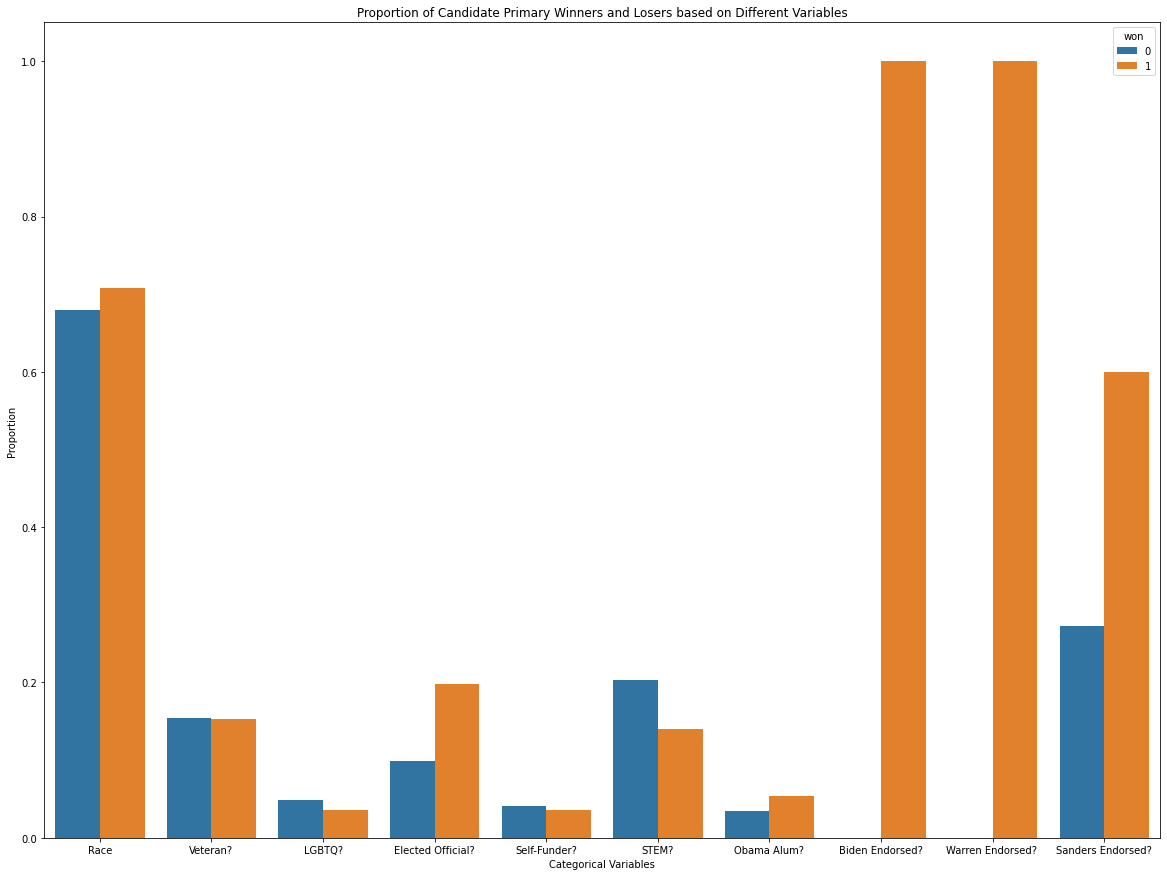

In [85]:
win = pd.DataFrame({'Categorical Variables': winners.columns, 'Proportion': winners.mean()})
lose = pd.DataFrame({'Categorical Variables': losers.columns, 'Proportion': losers.mean()})
win['won']=1
lose['won']=0
new=pd.concat([win, lose])
plt.figure(figsize=(20,15))
sns.barplot(x='Categorical Variables',y='Proportion',data=new,hue='won').set(title='Proportion of Candidate Primary Winners and Losers based on Different Variables')
plt.show()

As seen from the data above, we can see the most prominent differences in proportions between winners and losers occurred for the presidential endorsed candidates. This means that when the presidential candidates endorsed someone, they were very likely to win their Primary. Everyone endorsed by Biden and Warren won their primaries and 2/3s of the candidates endorsed by Sanders won their primaries. In terms of the other categorical variables, it seems like there were no major differences. The most notable ones being that if they were an elected official before they won their primary more often and if they were STEM they lost their primary more often. 

This visualization is directly related to our research question asking what variables affect if a candidate lost or won their election. We can see a rough estimate that presidential endorsements have a very large effect and should dive into this deeper. We should also look at the effects of the other categorical variables, like Elected Official and STEM, and see what the exact numerical effects on each are.


In [86]:
#Biden Endorsed
biden_endorsed = dem_cat.sort_values("Biden Endorsed?")
biden_endorsed = biden_endorsed.loc[biden_endorsed['Biden Endorsed?'] == "Yes"]
biden_endorsed = biden_endorsed[['Race', 'Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?', 'Obama Alum?']]
biden_endorsed["Race"] = biden_endorsed["Race"].map({'White':1,'Nonwhite':0})
biden_endorsed["Veteran?"] = biden_endorsed["Veteran?"].map({'Yes':1,'No':0})
biden_endorsed["LGBTQ?"] = biden_endorsed["LGBTQ?"].map({'Yes':1,'No':0})
biden_endorsed["Elected Official?"] = biden_endorsed["Elected Official?"].map({'Yes':1,'No':0})
biden_endorsed["Self-Funder?"] = biden_endorsed["Self-Funder?"].map({'Yes':1,'No':0})
biden_endorsed["STEM?"] = biden_endorsed["STEM?"].map({'Yes':1,'No':0})
biden_endorsed["Obama Alum?"] = biden_endorsed["Obama Alum?"].map({'Yes':1,'No':0})
#Sanders Endorsed 
sanders_endorsed = dem_cat.sort_values('Sanders Endorsed?')
sanders_endorsed = sanders_endorsed.loc[dem_cat['Sanders Endorsed?'] == "Yes"]
sanders_endorsed = sanders_endorsed[['Race', 'Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?', 'Obama Alum?']]
sanders_endorsed["Race"] = sanders_endorsed["Race"].map({'White':1,'Nonwhite':0})
sanders_endorsed["Veteran?"] = sanders_endorsed["Veteran?"].map({'Yes':1,'No':0})
sanders_endorsed["LGBTQ?"] = sanders_endorsed["LGBTQ?"].map({'Yes':1,'No':0})
sanders_endorsed["Elected Official?"] = sanders_endorsed["Elected Official?"].map({'Yes':1,'No':0})
sanders_endorsed["Self-Funder?"] = sanders_endorsed["Self-Funder?"].map({'Yes':1,'No':0})
sanders_endorsed["STEM?"] = sanders_endorsed["STEM?"].map({'Yes':1,'No':0})
sanders_endorsed["Obama Alum?"] = sanders_endorsed["Obama Alum?"].map({'Yes':1,'No':0})
#Warren Endorsed
warren_endorsed = dem_cat.sort_values('Warren Endorsed? ')
warren_endorsed = warren_endorsed.loc[dem_cat['Warren Endorsed? '] == "Yes"]
warren_endorsed = warren_endorsed[['Race', 'Veteran?', 'LGBTQ?', 'Elected Official?', 'Self-Funder?', 'STEM?', 'Obama Alum?']]
warren_endorsed["Race"] = warren_endorsed["Race"].map({'White':1,'Nonwhite':0})
warren_endorsed["Veteran?"] = warren_endorsed["Veteran?"].map({'Yes':1,'No':0})
warren_endorsed["LGBTQ?"] = warren_endorsed["LGBTQ?"].map({'Yes':1,'No':0})
warren_endorsed["Elected Official?"] = warren_endorsed["Elected Official?"].map({'Yes':1,'No':0})
warren_endorsed["Self-Funder?"] = warren_endorsed["Self-Funder?"].map({'Yes':1,'No':0})
warren_endorsed["STEM?"] = warren_endorsed["STEM?"].map({'Yes':1,'No':0})
warren_endorsed["Obama Alum?"] = warren_endorsed["Obama Alum?"].map({'Yes':1,'No':0})

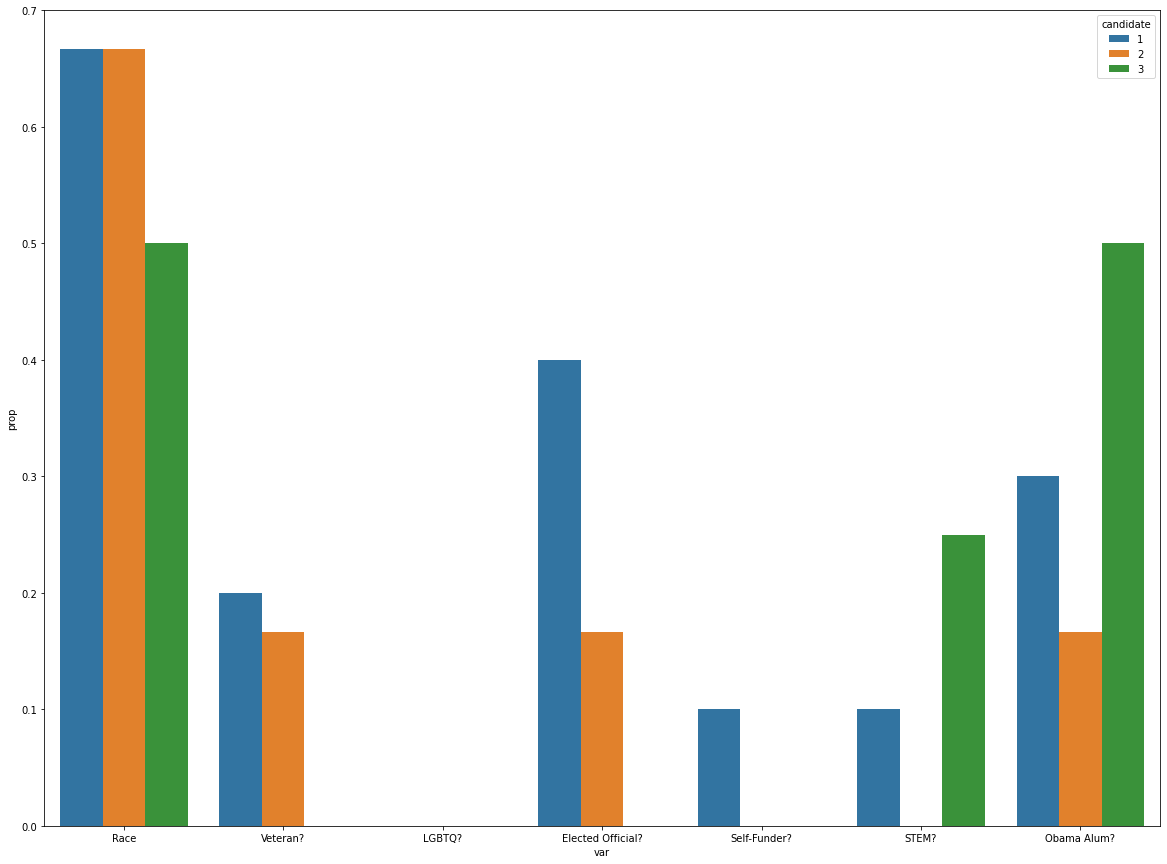

In [87]:
df1 = pd.DataFrame({'var': biden_endorsed.columns, 'prop': biden_endorsed.mean()})
df2 = pd.DataFrame({'var': sanders_endorsed.columns, 'prop': sanders_endorsed.mean()})
df3 = pd.DataFrame({'var': warren_endorsed.columns, 'prop': warren_endorsed.mean()})
df1['candidate']=1
df2['candidate']=2
df3['candidate']=3
res=pd.concat([df1,df2,df3])
plt.figure(figsize=(20,15))
sns.barplot(x='var',y='prop',data=res,hue='candidate')
plt.show()

Additionally, we decided to do a similar analysis on the same categorical variables except this time looking to see if there were differences between those endorsed by the presidential candidates. As seen from the graph, most endorsed by all candidates were white and not LGBTQ. The largest difference between the candidates was that Elizabeth Warren endorsed a much higher proportion of Obama Alumni compared to the other two candidates (about 60% compared to Biden’s 30% and Sander’s 10%). Another notable difference seemed to be that Biden had more Elected Officials endorsed compared to the other two presidential candidates. Overall this data relates to our analysis of the categorical variables and provides a deeper dive into the Presidential candidates’ endorsements. We may want to look into the specifics of each of these in our multiple hypothesis test.

Merging Democratic Candidate Data with Candidate Specific Donation Data

In [88]:
cand.head()

,Cand_Name,Cand_Id,Cand_Office,Cand_Office_St,Cand_Office_Dist,Total_Contribution,Surname,first_initial
3,"SIRES, ALBIO",H6NJ13191,H,NJ,8.0,459857.05,sires,A
7,"DETERS, BRIAN",H8IL18092,H,IL,18.0,20583.09,deters,B
8,"DAVIS, PAUL T.",H8KS02173,H,KS,2.0,3547064.51,davis,P
9,"MESSMER, JOHN P.",H8MO02232,H,MO,2.0,10258.00,messmer,J
10,"ANDRES, EDWARD H",H8MO06134,H,MO,6.0,12366.00,andres,E


In [89]:
dem.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,last_name,first_initial
6,Lizzetta Hill McConnell,AL,U.S. House Alabama District 1,Representative,Regular,6/5/18,Lost,None,None,-30.680000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mcconnell,L
7,Robert Kennedy Jr.,AL,U.S. House Alabama District 1,Representative,Regular,6/5/18,Advanced,None,On the Ballot,-30.680000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jr.,R
8,Audri Scott Williams,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,Lost,None,None,-33.080002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,williams,A
9,Tabitha Isner,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,Advanced,None,On the Ballot,-33.080002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,isner,T
10,Adia McClellan Winfrey,AL,U.S. House Alabama District 3,Representative,Regular,6/5/18,Lost,None,None,-33.660000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,winfrey,A


In [90]:
#Merging the two dataframes is necessary for including confounding variables from our "dem" table in our
#analysis for determining causations between donations and polling percentages.
joined = dem.merge(cand, how='inner', left_on=["last_name", "State", "first_initial"], right_on=["Surname", "Cand_Office_St", "first_initial"])
joined.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,No Labels Support?,last_name,first_initial,Cand_Name,Cand_Id,Cand_Office,Cand_Office_St,Cand_Office_Dist,Total_Contribution,Surname
0,Lizzetta Hill McConnell,AL,U.S. House Alabama District 1,Representative,Regular,6/5/18,Lost,None,None,-30.680000,...,NaN,mcconnell,L,"MCCONNELL, LIZZETTA HILL",H8AL01082,H,AL,1.0,5127.00,mcconnell
1,Audri Scott Williams,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,Lost,None,None,-33.080002,...,NaN,williams,A,"WILLIAMS, AUDRI SCOTT 1955",H8AL02163,H,AL,2.0,35365.02,williams
2,Tabitha Isner,AL,U.S. House Alabama District 2,Representative,Regular,6/5/18,Advanced,None,On the Ballot,-33.080002,...,NaN,isner,T,"ISNER, TABITHA KAY",H8AL02197,H,AL,2.0,524381.30,isner
3,Adia McClellan Winfrey,AL,U.S. House Alabama District 3,Representative,Regular,6/5/18,Lost,None,None,-33.660000,...,NaN,winfrey,A,"WINFREY, ADIA MCCLELLAN DR",H8AL03062,H,AL,3.0,9754.00,winfrey
4,Mallory Hagan,AL,U.S. House Alabama District 3,Representative,Regular,6/5/18,Advanced,None,On the Ballot,-33.660000,...,NaN,hagan,M,"HAGAN, MALLORY",H8AL03054,H,AL,3.0,440309.26,hagan


In [91]:
joined.shape

(540, 41)

In [92]:
#Duplicate Candidate values, typically due to same candidate running in multiple races
candidate_counts = joined["Candidate"].value_counts()
duplicate_candidates = candidate_counts.loc[candidate_counts == 2].index
joined.loc[joined["Candidate"].isin(duplicate_candidates)].head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,No Labels Support?,last_name,first_initial,Cand_Name,Cand_Id,Cand_Office,Cand_Office_St,Cand_Office_Dist,Total_Contribution,Surname
150,Paul Davis,KS,U.S. House Kansas District 2,Representative,Regular,8/7/18,Advanced,None,On the Ballot,-19.730000,...,NaN,davis,P,"DAVIS, PAUL T.",H8KS02173,H,KS,2.0,3547064.51,davis
188,Brenda Jones,MI,U.S. House Michigan District 13,Representative,Special,8/7/18,Advanced,None,On the Ballot,60.720001,...,NaN,jones,B,"JONES, BRENDA",H8MI13243,H,MI,13.0,270331.00,jones
189,Brenda Jones,MI,U.S. House Michigan District 13,Representative,Regular,8/7/18,Lost,None,None,60.720001,...,NaN,jones,B,"JONES, BRENDA",H8MI13243,H,MI,13.0,270331.00,jones
190,Ian Conyers,MI,U.S. House Michigan District 13,Representative,Regular,8/7/18,Lost,None,None,60.720001,...,NaN,conyers,I,"CONYERS, IAN",H8MI13284,H,MI,13.0,212675.58,conyers
191,Ian Conyers,MI,U.S. House Michigan District 13,Representative,Special,8/7/18,Lost,None,None,60.720001,...,NaN,conyers,I,"CONYERS, IAN",H8MI13284,H,MI,13.0,212675.58,conyers


In [93]:
#Candidates with most amount of donations
joined["Total_Contribution"] = joined["Total_Contribution"].astype(int)
non_zero_donations = joined.loc[joined["Total_Contribution"] != 0]
non_zero_donations.sort_values("Total_Contribution", ascending=False).head(10)[["Candidate", "Total_Contribution"]]

,Candidate,Total_Contribution
279,Jacky Rosen,24229498
419,Phil Bredesen,10891001
27,Andrew Janz,9076195
290,Antonio Delgado,8616934
317,Danny O'Connor,8472054
316,Danny O'Connor,8472054
166,Amy McGrath,7990931
21,Josh Harder,7762575
36,Katie Hill,7654693
529,Abigail Spanberger,6688317


Jacky Rosen is a clear outlier in terms of amount of donations received, let's remove her for the sake of creating a more representative visualization.

Text(0.5, 0, 'Donations in Dollars (Logged)')

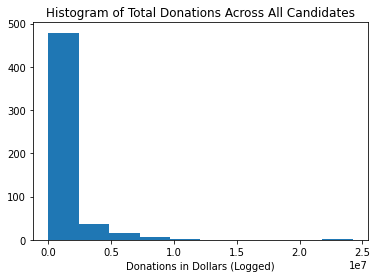

In [94]:
#non_zero_donations = non_zero_donations.loc[non_zero_donations["Candidate"] != "Jacky Rosen"]
plt.hist(non_zero_donations["Total_Contribution"])
plt.title("Histogram of Total Donations Across All Candidates")
plt.xlabel("Donations in Dollars (Logged)")

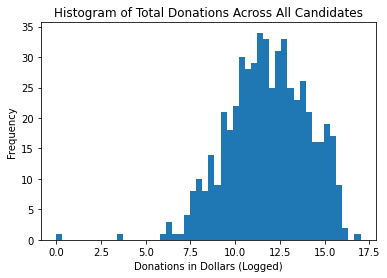

In [95]:
plt.hist(np.log(non_zero_donations["Total_Contribution"]), bins=50)
plt.title("Histogram of Total Donations Across All Candidates")
plt.xlabel("Donations in Dollars (Logged)")
plt.ylabel("Frequency");

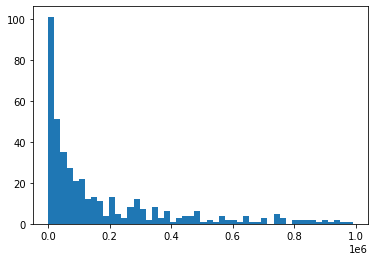

In [96]:
fewer_donations = non_zero_donations.loc[non_zero_donations["Total_Contribution"] < 1000000]
plt.hist(fewer_donations["Total_Contribution"], bins=50);

In [97]:
joined[joined['Office Type'] == "Senator"]

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,No Labels Support?,last_name,first_initial,Cand_Name,Cand_Id,Cand_Office,Cand_Office_St,Cand_Office_Dist,Total_Contribution,Surname
182,Zak Ringelstein,ME,U.S. Senate Maine,Senator,Regular,6/12/18,Advanced,None,On the Ballot,3.510000,...,NaN,ringelstein,Z,"RINGELSTEIN, ZACKARY (ZAK)",S8ME00155,S,ME,0.0,151184,ringelstein
217,David Baria,MS,U.S. Senate Mississippi,Senator,Regular,6/5/18,Advanced,Advanced,On the Ballot,-18.780001,...,NaN,baria,D,"BARIA, DAVID WAYNE",S8MS00253,S,MS,0.0,904539,baria
218,Howard Sherman,MS,U.S. Senate Mississippi,Senator,Regular,6/5/18,Advanced,Lost,None,-18.780001,...,NaN,sherman,H,"SHERMAN, HOWARD",S8MS00246,S,MS,0.0,267911,sherman
219,Jensen Bohren,MS,U.S. Senate Mississippi,Senator,Regular,6/5/18,Lost,None,None,-18.780001,...,NaN,bohren,J,"BOHREN, JENSEN MR",S8MS00220,S,MS,0.0,1994,bohren
220,Jerone Garland,MS,U.S. Senate Mississippi,Senator,Regular,6/5/18,Lost,None,None,-18.780001,...,NaN,garland,J,"GARLAND, JAMES JERONE",S8MS00279,S,MS,0.0,601,garland
248,Frank Svoboda,NE,U.S. Senate Nebraska,Senator,Regular,5/15/18,Lost,None,None,-26.760000,...,NaN,svoboda,F,"SVOBODA, FRANK B",S8NE00224,S,NE,0.0,16000,svoboda
249,Jane Raybould,NE,U.S. Senate Nebraska,Senator,Regular,5/15/18,Advanced,None,On the Ballot,-26.760000,...,NaN,raybould,J,"RAYBOULD, JANE",S8NE00182,S,NE,0.0,2042990,raybould
279,Jacky Rosen,NV,U.S. Senate Nevada,Senator,Regular,6/12/18,Advanced,None,On the Ballot,0.950000,...,NaN,rosen,J,"ROSEN, JACKY",S8NV00156,S,NV,0.0,24229498,rosen
280,Jesse Sbaih,NV,U.S. Senate Nevada,Senator,Regular,6/12/18,Lost,None,None,0.950000,...,NaN,sbaih,J,"SBAIH, JESSE",S8NV00149,S,NV,0.0,105775,sbaih
419,Phil Bredesen,TN,U.S. Senate Tennessee,Senator,Regular,8/2/18,Advanced,None,On the Ballot,-27.139999,...,NaN,bredesen,P,"BREDESEN, PHILIP",S8TN00386,S,TN,0.0,10891001,bredesen


We also wanted to see how contribution amounts differed based on whether candidates won or lost. First, we found the log of total contribution amounts, in order to make processing and visualization easier: 

In [98]:
joined["Log_Contribution"] = np.log(joined["Total_Contribution"])

We then generated a boxplot, separated by whether candidates won or lost:

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


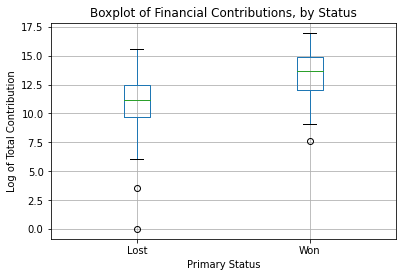

In [99]:
boxplot = joined.boxplot(column=['Log_Contribution'],by="General Status")
boxplot.plot()

plt.title("Boxplot of Financial Contributions, by Status")
plt.suptitle('')
plt.xlabel('Primary Status')
plt.ylabel('Log of Total Contribution')
plt.xticks([1, 2], ['Lost', 'Won'])
plt.show();

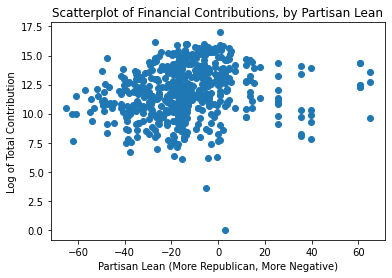

In [100]:
plt.scatter(joined["Partisan Lean"], joined["Log_Contribution"])

plt.title("Scatterplot of Financial Contributions, by Partisan Lean")
plt.xlabel('Partisan Lean (More Republican, More Negative)')
plt.ylabel('Log of Total Contribution')
plt.show();

## Multiple Hypotheis Testing

# Frame Cleanup

In [101]:
# Cleaning dem_cat DataFrame
dem_cat['Won Primary'] = dem_cat['Won Primary'].map({'Yes':1,'No':0})
dem_cat['Race'] = dem_cat['Race'].map({'White':1,'Nonwhite':0})
dem_cat['Party'] = 'Dem'
dem_cat.head()

,Won Primary,Race,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Obama Alum?,Party Support?,Emily Endorsed?,...,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,last_name,first_initial,Party
6,0,0.0,No,No,No,No,Yes,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mcconnell,L,Dem
7,1,0.0,Yes,No,No,No,No,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,jr.,R,Dem
8,0,0.0,Yes,No,No,No,No,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,williams,A,Dem
9,1,1.0,No,No,No,No,No,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,isner,T,Dem
10,0,0.0,No,No,No,No,Yes,No,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,winfrey,A,Dem


In [102]:
# Cleaning rep_test DataFrame
rep_test['Won Primary'] = rep_test['Won Primary'].map({'Yes':1, 'No':0})
rep_test['Race Type'] = rep_test['Race Type'].map({'Special':1, 'Regular':0})
rep_test['Primary Status'] = rep_test['Primary Status'].map({'Advanced':1, 'Lost':0, 'On the Ballot':0})
rep_test['Party'] = 'Rep'
rep_test.head()

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Primary %,...,Right to Life Endorsed?,Susan B. Anthony Endorsed?,Club for Growth Endorsed?,Koch Support?,House Freedom Support?,Tea Party Endorsed?,Main Street Endorsed?,Chamber Endorsed?,No Labels Support?,Party
0,Mike Dunleavy,AK,Governor of Alaska,Governor,0.0,8/21/18,1,None,On the Ballot,61.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rep
1,Michael Sheldon,AK,Governor of Alaska,Governor,0.0,8/21/18,0,None,None,2.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rep
2,Mead Treadwell,AK,Governor of Alaska,Governor,0.0,8/21/18,0,None,None,31.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rep
3,Darin Colbry,AK,Governor of Alaska,Governor,0.0,8/21/18,0,None,None,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rep
4,Thomas Gordon,AK,Governor of Alaska,Governor,0.0,8/21/18,0,None,None,1.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Rep



# Functions

In [103]:
def CleanFrame(dataframe):
  dataframe = dataframe.replace({'Yes':1,'No':0})
  return dataframe

def ShuffleDiff(data, col):
  differences = []
  seed = np.arange(1000)

  for i in np.arange(1000):
      shuffled_labels = data.sample(frac = 1,replace = False, random_state = seed[i])[col].reset_index(drop = True)
      data["Shuffled Label"] = shuffled_labels
      new = data[['Shuffled Label', 'Won Primary']]
      means = new.groupby('Shuffled Label').mean()
      means_diff = float(means.iloc[0] - means.iloc[1])
      differences = np.append(differences, means_diff)

  return differences

def pscore(diffs, props, iter_lim=1000):
  count = 0

  for i in diffs:
    if i <= props:
      count += 1

  p_value = count/iter_lim
  return p_value

def GetPValue(table, prim_col, col_to_compare):
  
  reduced = table[[prim_col, col_to_compare]].replace({'Yes':1, 'No':0}).dropna().reset_index(drop = True)
  obs_prop = float(reduced.groupby(col_to_compare).mean().iloc[0] - reduced.groupby(col_to_compare).mean().iloc[1])

  differences = ShuffleDiff(reduced, col_to_compare)

  p_val = pscore(differences, obs_prop)

  return p_val, obs_prop, differences

def plotting_temp(diffs, obs, col_to_compare):
  plt.hist(diffs, density=True)
  plt.suptitle('Prediction under the Null Hypothesis for '+col_to_compare)
  plt.xlabel("Difference in proportion")
  plt.ylabel("Percent Per Unit")
  plt.axvline(x = obs, color = 'r', label = 'Observed difference in means for '+col_to_compare)

# Group Hypothesis: Candidate Attributes and Primary Results

In [104]:
dem_cand_attributes = dem_cat[['Won Primary', 'Race', 'Veteran?', 'LGBTQ?', 'Self-Funder?', 'STEM?', 'Obama Alum?']].fillna(0)
dem_cand_attributes = CleanFrame(dem_cand_attributes)
dem_cand_attributes.head()

,Won Primary,Race,Veteran?,LGBTQ?,Self-Funder?,STEM?,Obama Alum?
6,0,0.0,0,0,0,1,0
7,1,0.0,1,0,0,0,0
8,0,0.0,1,0,0,0,0
9,1,1.0,0,0,0,0,0
10,0,0.0,0,0,0,1,0


**Hypothesis #1: Race** 

In [105]:
p_val_race, obs_race, diff_race = GetPValue(dem_cand_attributes, 'Won Primary', 'Race') ###
print(p_val_race, obs_race)

0.28 -0.023772153831796317


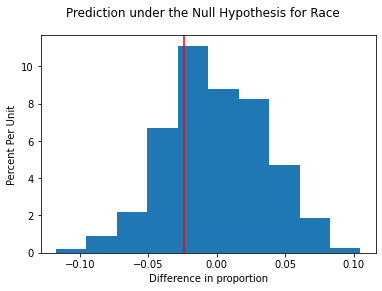

In [106]:
plotting_temp(diff_race, obs_race, 'Race')

In [107]:
GetPValue(dem_cand_attributes, 'Won Primary', 'Veteran?')[:2]

(0.552, 0.0011630912380460323)

In [108]:
GetPValue(dem_cand_attributes, 'Won Primary', 'LGBTQ?')[:2]

(0.836, 0.06666993000146848)

In [109]:
GetPValue(dem_cand_attributes, 'Won Primary', 'Self-Funder?')[:2]

(0.679, 0.02647896765543828)

In [110]:
GetPValue(dem_cand_attributes, 'Won Primary', 'Self-Funder?')[:2]

(0.679, 0.02647896765543828)

**Hypothesis #2: Obama Alumni**

In [111]:
p_val_Obama, obs_Obama, diff_Obama = GetPValue(dem_cand_attributes, 'Won Primary', 'Obama Alum?') ##
print(p_val_Obama, obs_Obama)

0.171 -0.111350884764782


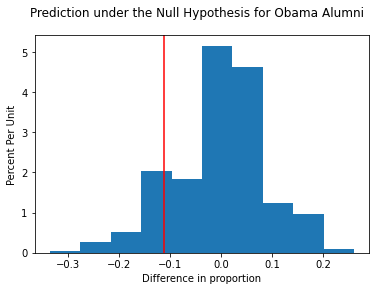

In [112]:
plotting_temp(diff_Obama, obs_Obama, 'Obama Alumni')

# Group Hypothesis: Political Figure Support and Primary Results

In [137]:
dem_people_endorsements = dem_cat[['Won Primary', 'Emily Endorsed?', 'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?']].fillna(0)
dem_people_endorsements = CleanFrame(dem_people_endorsements)
dem_people_endorsements.head()

,Won Primary,Emily Endorsed?,Biden Endorsed?,Warren Endorsed?,Sanders Endorsed?
6,0,0,0,0,0
7,1,0,0,0,0
8,0,0,0,0,0
9,1,0,0,0,0
10,0,0,0,0,0


In [138]:
GetPValue(dem_people_endorsements, 'Won Primary', 'Emily Endorsed?')[:2]

(0.0, -0.40887981987053196)

**Hypothesis #3: Biden Endorsed**

In [139]:
p_val_Biden, obs_Biden, diff_Biden = GetPValue(dem_people_endorsements, 'Won Primary', 'Biden Endorsed?') ## 0.5
print(p_val_Biden, obs_Biden)

0.0 -0.6882352941176471


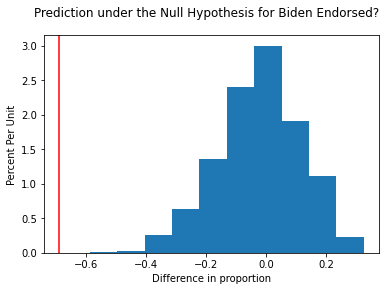

In [140]:
plotting_temp(diff_Biden, obs_Biden, 'Biden Endorsed?')

In [141]:
GetPValue(dem_people_endorsements, 'Won Primary', 'Warren Endorsed? ')[:2]

(0.016, -0.6822157434402332)

**Hypothesis #4: Sanders Endorsed**

In [142]:
p_val_Sanders, obs_Sanders, diff_Sanders = GetPValue(dem_people_endorsements, 'Won Primary', 'Sanders Endorsed?') ## 0.5
print(p_val_Sanders, obs_Sanders)

0.298 -0.17982456140350878


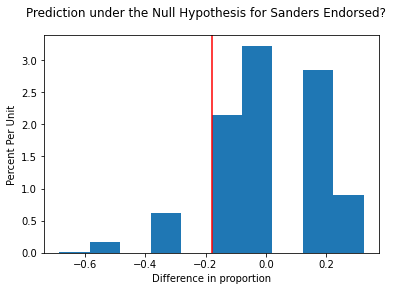

In [143]:
plotting_temp(diff_Sanders, obs_Sanders, 'Sanders Endorsed?')

In [145]:
rep_people_endorsements = rep_test[['Won Primary', 'Trump Endorsed?', 'Bannon Endorsed?', 'Susan B. Anthony Endorsed?', 'Koch Support?']].fillna(0)
rep_people_endorsements = CleanFrame(rep_people_endorsements)
rep_people_endorsements.head()

,Won Primary,Trump Endorsed?,Bannon Endorsed?,Susan B. Anthony Endorsed?,Koch Support?
0,1,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


**Hypothesis #5: Trump Endorsed**

In [146]:
p_val_Trump, obs_Trump, diff_Trump = GetPValue(rep_people_endorsements, 'Won Primary', 'Trump Endorsed?') # 0.5
print(p_val_Trump, obs_Trump)

0.0 -0.5785220296837361


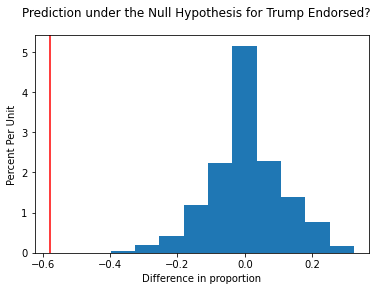

In [147]:
plotting_temp(diff_Trump, obs_Trump, 'Trump Endorsed?')

**Hypothesis #6: Bannon Endorsed**

In [148]:
p_val_Bannon, obs_Bannon, diff_Bannon = GetPValue(rep_people_endorsements, 'Won Primary', 'Bannon Endorsed?')
print(p_val_Bannon, obs_Bannon)

0.009 -0.43798955613577023


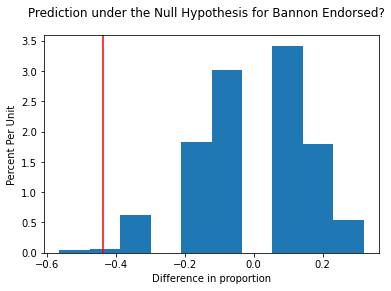

In [149]:
plotting_temp(diff_Bannon, obs_Bannon, 'Bannon Endorsed?')

In [150]:
GetPValue(rep_people_endorsements, 'Won Primary', 'Susan B. Anthony Endorsed?')[:2]

(0.029, -0.21148613442945635)

In [151]:
GetPValue(rep_people_endorsements, 'Won Primary', 'Koch Support?')[:2]

(0.0, -0.5556820337696831)

# Group Hypothesis : Group Endorsements and Primary Results

In [152]:
dem_group_support = dem_cat[['Won Primary', 'Party Support?', 'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 'PCCC Endorsed?', 'Indivisible Endorsed?', 'WFP Endorsed?', 'No Labels Support?']].fillna(0)
dem_group_support = CleanFrame(dem_group_support)
dem_group_support.head()

,Won Primary,Party Support?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,No Labels Support?
6,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0


**Hypothesis #7: Democratic Party Endorsed**

In [153]:
p_val_dem, obs_dem, diff_dem = GetPValue(dem_group_support, 'Won Primary', 'Party Support?')  ##
print(p_val_dem, obs_dem)

0.0 -0.6620923474329996


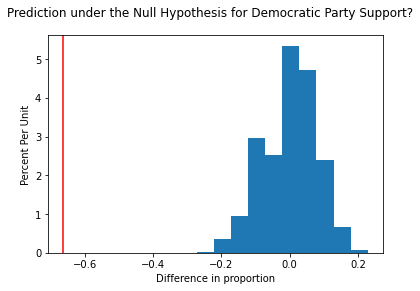

In [154]:
plotting_temp(diff_dem, obs_dem, 'Democratic Party Support?')

In [155]:
GetPValue(dem_group_support, 'Won Primary', 'Our Revolution Endorsed?')[:2]

(0.49, -0.007859505783619325)

In [156]:
GetPValue(dem_group_support, 'Won Primary', 'Justice Dems Endorsed?')[:2]

(0.675, 0.018633540372670787)

**Hypothesis #9: PCCC Endorsed**

In [157]:
p_val_pccc, obs_pccc, diff_pccc = GetPValue(dem_group_support, 'Won Primary', 'PCCC Endorsed?') ##
print(p_val_pccc, obs_pccc)

0.003 -0.4358407079646018


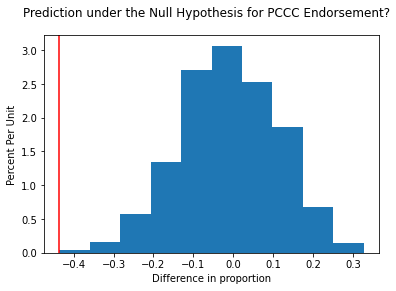

In [158]:
plotting_temp(diff_pccc, obs_pccc, 'PCCC Endorsement?')

In [159]:
GetPValue(dem_group_support, 'Won Primary', 'Indivisible Endorsed?')[:2]

(0.0, -0.37500000000000006)

**Hypothesis #10: WFP Endorsed**

In [160]:
p_val_WFP, obs_WFP, diff_WFP = GetPValue(dem_group_support, 'Won Primary', 'WFP Endorsed?') ##
print(p_val_WFP, obs_WFP)

0.009 -0.2518740629685157


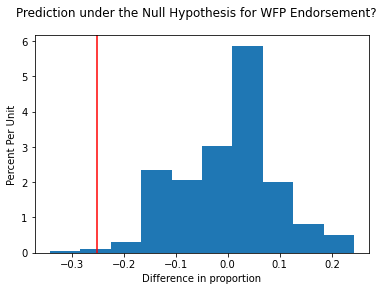

In [161]:
plotting_temp(diff_WFP, obs_WFP, 'WFP Endorsement?')

In [162]:
GetPValue(dem_group_support, 'Won Primary', 'No Labels Support?')[:2]

(1.0, 0.3226744186046512)

In [163]:
rep_group_support = rep_test[['Won Primary', 'Rep Party Support?', 'Great America Endorsed?', 'NRA Endorsed?', 'Right to Life Endorsed?', 
                                    'Club for Growth Endorsed?', 'House Freedom Support?', 'Tea Party Endorsed?', 'Main Street Endorsed?', 'Chamber Endorsed?', 'No Labels Support?']].fillna(0)
rep_group_support = CleanFrame(rep_group_support)
rep_group_support.head()

,Won Primary,Rep Party Support?,Great America Endorsed?,NRA Endorsed?,Right to Life Endorsed?,Club for Growth Endorsed?,House Freedom Support?,Tea Party Endorsed?,Main Street Endorsed?,Chamber Endorsed?,No Labels Support?
0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0


**Hypothesis #9: Republican Party Endorsed**

In [164]:
p_val_rep, obs_rep, diff_rep = GetPValue(rep_group_support, 'Won Primary', 'Rep Party Support?') ##
print(p_val_WFP, obs_WFP)

0.009 -0.2518740629685157


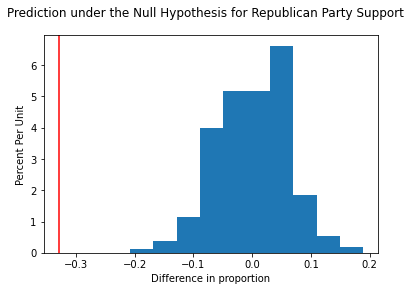

In [165]:
plotting_temp(diff_rep, obs_rep, 'Republican Party Support')

In [166]:
GetPValue(rep_group_support, 'Won Primary', 'Great America Endorsed?')[:2]

(0.035, -0.40137828273421494)

**Hypothesis #11: NRA Endorsed**

In [167]:
p_val_nra, obs_nra, diff_nra = GetPValue(rep_group_support, 'Won Primary', 'NRA Endorsed?') ##
print(p_val_nra, obs_nra)


0.048 -0.2595864661654135


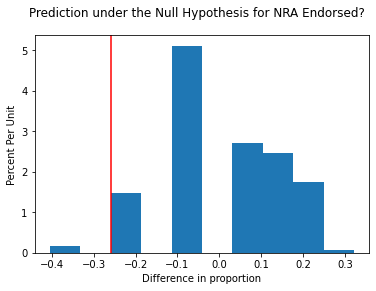

In [168]:
plotting_temp(diff_nra, obs_nra, 'NRA Endorsed?')

**Hypothesis #12: National Right to Life Commitee Endorsed**

In [169]:
p_val_life, obs_life, diff_life = GetPValue(rep_group_support, 'Won Primary', 'Right to Life Endorsed?') ##
print(p_val_life, obs_life)

0.01 -0.14308880308880306


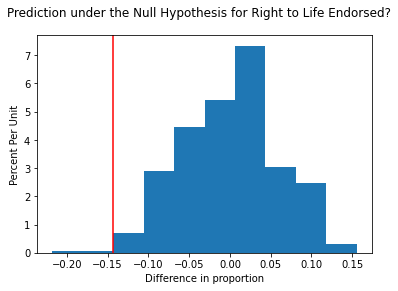

In [170]:
plotting_temp(diff_life, obs_life, 'Right to Life Endorsed?')

In [171]:
GetPValue(rep_group_support, 'Won Primary', 'Club for Growth Endorsed?')[:2]

(0.003, -0.3109466894327452)

In [172]:
GetPValue(rep_group_support, 'Won Primary', 'House Freedom Support?')[:2]

(0.114, -0.18684210526315792)

In [173]:
GetPValue(rep_group_support, 'Won Primary', 'Tea Party Endorsed?')[:2]

(0.01, -0.3149736147757256)

In [174]:
GetPValue(rep_group_support, 'Won Primary', 'Main Street Endorsed?')[:2]

(0.007, -0.3379438961846298)

In [175]:
GetPValue(rep_group_support, 'Won Primary', 'Chamber Endorsed?')[:2]

(0.066, -0.3116840731070496)

In [176]:
GetPValue(rep_group_support, 'Won Primary', 'No Labels Support?')[:2]

(0.539, -0.18393782383419688)

In [177]:
dem_veteran_history = dem_cat[['Won Primary', 'Veteran?', 'VoteVets Endorsed?']].fillna(0)
dem_veteran_history = CleanFrame(dem_veteran_history)
dem_veteran_history.head()

,Won Primary,Veteran?,VoteVets Endorsed?
6,0,0,0
7,1,1,0
8,0,1,0
9,1,0,0
10,0,0,0


In [178]:
GetPValue(dem_veteran_history, 'Won Primary', 'Veteran?')[:2]

(0.552, 0.0011630912380460323)

In [179]:
GetPValue(dem_veteran_history, 'Won Primary', 'VoteVets Endorsed?')[:2]

(0.01, -0.24333836098541983)

(array([0.05914197, 0.53227772, 1.50812021, 4.02165389, 6.94918135,
        7.74759793, 5.26363523, 2.30653679, 1.00541347, 0.17742591]),
 array([-0.17248388, -0.13866695, -0.10485001, -0.07103308, -0.03721615,
        -0.00339922,  0.03041772,  0.06423465,  0.09805158,  0.13186852,
         0.16568545]),
 <a list of 10 Patch objects>)

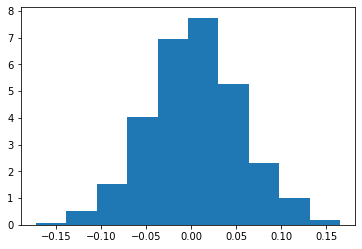

In [180]:
diff_dem_veteran_history = ShuffleDiff(dem_veteran_history, 'Veteran?')
plt.hist(diff_dem_veteran_history, density=True)

# Multiple Hypothesis Corrections

In [182]:
all_p_values = [p_val_race, p_val_Obama, p_val_Biden, p_val_Sanders, p_val_Trump, p_val_Bannon, p_val_dem, p_val_rep, p_val_pccc, p_val_WFP, p_val_nra, p_val_life]
all_p_values.sort()
all_p_values

[0.0, 0.0, 0.0, 0.0, 0.003, 0.009, 0.009, 0.01, 0.048, 0.171, 0.28, 0.298]

In [183]:
N = 12
k = np.arange(1, 13)
alpha = 0.05
bonferroni = alpha/N
b_h = k/N * alpha

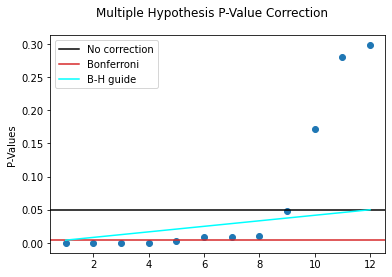

In [184]:
plt.scatter(k, all_p_values)
plt.axhline(alpha, label='No correction', color='black')
plt.axhline(alpha / N, label='Bonferroni', color='tab:red')
plt.plot(k, k/N * alpha, label='B-H guide', color='cyan')
plt.suptitle('Multiple Hypothesis P-Value Correction')
plt.ylabel("P-Values")
plt.legend();

In [185]:
bonferroni

0.004166666666666667

In [186]:
b_h

array([0.00416667, 0.00833333, 0.0125    , 0.01666667, 0.02083333,
       0.025     , 0.02916667, 0.03333333, 0.0375    , 0.04166667,
       0.04583333, 0.05      ])

# Causality Analysis

In [113]:
unrelated_variables = ["Race Primary Election Date", "Primary Status", "Primary Runoff Status", "last_name", "first_initial",
                "Cand_Name", "Cand_Id", "Cand_Office", "Surname", "Race Type", "Office Type", "General Status",
                      "Cand_Office_St", "Cand_Office_Dist", "State", "District", "Candidate"]
caus = joined.drop(labels=unrelated_variables, axis=1)

In [114]:
caus.shape

(540, 25)

In [115]:
caus["Race"].fillna('White', inplace=True)
caus["Race"] = caus["Race"].map({'White':1,'Nonwhite':0})
caus["White?"] = caus["Race"]
caus.drop("Race", axis = 1, inplace = True)

In [116]:
#Dropping the few rows in which 'Primary %' field is missing
caus.dropna(axis=0, subset=["Primary %"], inplace=True)
#Filling Null values with 'No' so as to binarize some of the categorical variables where applicable
caus.fillna('No', inplace=True)

In [117]:
#Dropping data where contribution amounts are equal to 0
caus = caus.drop(caus[caus["Total_Contribution"] == 0].index)
caus = caus.drop(axis=1, labels=["Total_Contribution"])

In [118]:
binary_variables = ['Veteran?', 'LGBTQ?',
       'Elected Official?', 'Self-Funder?', 'STEM?', 'Obama Alum?',
       'Party Support?', 'Emily Endorsed?', 'Guns Sense Candidate?',
       'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?',
       'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 'PCCC Endorsed?',
       'Indivisible Endorsed?', 'WFP Endorsed?', 'VoteVets Endorsed?',
       'No Labels Support?', 'Won Primary']
for feature in binary_variables:
  caus[feature] = caus[feature].map({'Yes':1,'No':0})

caus.shape

(540, 24)

In [119]:
caus.head()

,Partisan Lean,Primary %,Won Primary,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Obama Alum?,Party Support?,...,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,Log_Contribution,White?
0,-30.680000,19.230000,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,8.542276,0
1,-33.080002,39.560001,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10.473478,0
2,-33.080002,60.439999,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,13.169974,1
3,-33.660000,34.240002,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,9.185433,0
4,-33.660000,65.739998,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12.995232,1


In [120]:
from sklearn.linear_model import LinearRegression

In [121]:
X = caus.drop(axis=1, labels=["Primary %", "Won Primary"])
y = caus["Primary %"]
model = LinearRegression()
fitted = model.fit(X, y)

In [122]:
fitted.score

<bound method RegressorMixin.score of LinearRegression()>

In [123]:
logged_contribution_coefficient = fitted.coef_[-1]

In [124]:
fitted.coef_

array([-0.68797562, -2.77039498, -7.02838536,  9.01600717, -9.19420376,
       -1.39221775, -2.66438354, 18.49882516,  5.27828994, -1.4119679 ,
       11.90739309, -7.08001584, 14.9379175 ,  0.47714961,  2.06206577,
        5.45852178,  8.38586306,  1.28472457, -1.82697236,  1.39594119,
        4.92721113, -5.77852793])

In [125]:
caus.columns

Index(['Partisan Lean', 'Primary %', 'Won Primary', 'Veteran?', 'LGBTQ?',
       'Elected Official?', 'Self-Funder?', 'STEM?', 'Obama Alum?',
       'Party Support?', 'Emily Endorsed?', 'Guns Sense Candidate?',
       'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?',
       'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 'PCCC Endorsed?',
       'Indivisible Endorsed?', 'WFP Endorsed?', 'VoteVets Endorsed?',
       'No Labels Support?', 'Log_Contribution', 'White?'],
      dtype='object')

In [126]:
fitted.score(X, y)

0.4585369691684843

In [127]:
caus

,Partisan Lean,Primary %,Won Primary,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Obama Alum?,Party Support?,...,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,Log_Contribution,White?
0,-30.680000,19.230000,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,8.542276,0
1,-33.080002,39.560001,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10.473478,0
2,-33.080002,60.439999,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,13.169974,1
3,-33.660000,34.240002,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,9.185433,0
4,-33.660000,65.739998,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,12.995232,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,-35.330002,37.430000,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,13.018566,1
536,-35.330002,62.570000,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,13.445213,1
537,-47.480000,15.960000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9.131297,1
538,-47.480000,52.160000,1,1,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0,14.821446,0


In [128]:
np.asarray(caus)

array([[-30.68      ,  19.23      ,   0.        , ...,   0.        ,
          8.54227597,   0.        ],
       [-33.080002  ,  39.560001  ,   0.        , ...,   0.        ,
         10.47347791,   0.        ],
       [-33.080002  ,  60.439999  ,   1.        , ...,   0.        ,
         13.1699738 ,   1.        ],
       ...,
       [-47.48      ,  15.96      ,   0.        , ...,   0.        ,
          9.13129716,   1.        ],
       [-47.48      ,  52.16      ,   1.        , ...,   0.        ,
         14.82144563,   0.        ],
       [-47.48      ,  24.639999  ,   0.        , ...,   0.        ,
          8.29404964,   1.        ]])

In [129]:
bins = [-np.inf, np.log(100000), np.inf]
names = ['0', '1']

caus['Large Contribution?'] = pd.cut(caus['Log_Contribution'], bins, labels=names)
caus["Large Contribution?"] = caus["Large Contribution?"].astype(int)

In [130]:
caus["Large Contribution?"].value_counts()

1    303
0    237
Name: Large Contribution?, dtype: int64

In [131]:
vars_of_interest2 = ['Veteran?', 'LGBTQ?', 'White?',
       'Elected Official?', 'Self-Funder?', 'STEM?', 'Obama Alum?',
       'Party Support?', 'Emily Endorsed?', 'Guns Sense Candidate?',
       'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?',
       'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 'PCCC Endorsed?',
       'Indivisible Endorsed?', 'WFP Endorsed?', 'VoteVets Endorsed?',
       'No Labels Support?', 'Partisan Lean', 'Log_Contribution']
caus_model2 = sm.OLS(caus["Primary %"], sm.add_constant(caus[vars_of_interest2])).fit()
print(caus_model2.summary())

                            OLS Regression Results                            
Dep. Variable:              Primary %   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     19.90
Date:                Tue, 10 May 2022   Prob (F-statistic):           2.61e-55
Time:                        05:16:52   Log-Likelihood:                -2390.3
No. Observations:                 540   AIC:                             4827.
Df Residuals:                     517   BIC:                             4925.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [132]:
vars_of_interest = ['Veteran?', 'LGBTQ?', 'White?',
       'Elected Official?', 'Self-Funder?', 'STEM?', 'Obama Alum?',
       'Party Support?', 'Emily Endorsed?', 'Guns Sense Candidate?',
       'Biden Endorsed?', 'Warren Endorsed? ', 'Sanders Endorsed?',
       'Our Revolution Endorsed?', 'Justice Dems Endorsed?', 'PCCC Endorsed?',
       'Indivisible Endorsed?', 'WFP Endorsed?', 'VoteVets Endorsed?',
       'No Labels Support?', 'Partisan Lean', 'Large Contribution?']
caus_model = sm.OLS(caus["Primary %"], sm.add_constant(caus[vars_of_interest])).fit()
print(caus_model.summary())

                            OLS Regression Results                            
Dep. Variable:              Primary %   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     18.59
Date:                Tue, 10 May 2022   Prob (F-statistic):           4.86e-52
Time:                        05:16:52   Log-Likelihood:                -2398.5
No. Observations:                 540   AIC:                             4843.
Df Residuals:                     517   BIC:                             4942.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [133]:
vars_of_interest.remove("Large Contribution?")

In [134]:
from sklearn.linear_model import LogisticRegression as LR
lr = LR(penalty='none', max_iter=500, random_state=0)
lr.fit(caus[vars_of_interest], caus["Large Contribution?"]);

In [135]:
def estimate_treatment_effect(lr = lr, df = caus, 
                              X = vars_of_interest, Y = "Primary %", Z = "Large Contribution?"):
    df['pred'] = lr.predict_proba(df[X]).T[1]
    df2 = df[(df.pred > 0.1) & (df.pred < 0.9)]
    return np.average((df2[Z] * df2[Y]) / df2['pred'] - ((1 - df2[Z]) * df2[Y]) / (1 - df2['pred']))

In [136]:
estimate_treatment_effect()

19.435214425532845